In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as func # 与nn.Module类似，但有区别，在于其声明的layer是没有可训练参数的

import scipy.io as scio
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt

dtype = torch.float
device = torch.device("cpu")
#device_data = torch.device("cuda:0")
#device_train = torch.device("cuda:0")
#device_test = torch.device("cuda:0")
device_data = torch.device("cpu")
device_train = torch.device("cpu")
device_test = torch.device("cpu")

StartWL = 400
EndWL = 701
Resolution = 10
WL = np.arange(StartWL, EndWL, Resolution)
SpectralSliceNum = WL.size

# 薄膜结构-网络声明

In [2]:

class thinfilm_HybridNet(nn.Module): # 继承nn.Module
    # 初始化所需参数：CCDQE,PCSED网络层数/数组,网络计算设备/字符串
    def __init__(self,fnet_path, thick_min, thick_max,K,tc,h_p,c_light,pixel_S,WL,filter_data,size, device):
        # 利用父类初始化函数进行初始化
        super(thinfilm_HybridNet, self).__init__() 
        
        self.fnet = nn.Sequential(
            nn.Linear(10, 200), # FC 10-200

            nn.BatchNorm1d(200), # BN
            #nn.LeakyReLU(inplace=True),# relu分段函数的特殊形式，即x小于0时斜率远小于1但不为0
            nn.PReLU(200,init=0.01),
            #self.SWNet.add_module('PRelu0',nn.PReLU(num_parameters=size[1], init=0.01))
            nn.Linear(200, 800),# FC 200-800

            nn.BatchNorm1d(800),
            #nn.LeakyReLU(inplace=True),
            nn.PReLU(800,init=0.01),
            nn.Linear(800, 800),
            #nn.Dropout(0.1),

            nn.BatchNorm1d(800),
            #nn.LeakyReLU(inplace=True),
            nn.PReLU(800,init=0.01),
            nn.Linear(800, 800),
            #nn.Dropout(0.1),

            nn.BatchNorm1d(800),
            #nn.LeakyReLU(inplace=True),
            nn.PReLU(800,init=0.01),
            nn.Linear(800, 800),
            #nn.Dropout(0.1),

            nn.BatchNorm1d(800),
            #nn.LeakyReLU(inplace=True),
            nn.PReLU(800,init=0.01),
            nn.Linear(800, 31),
            #nn.Dropout(0.1),

            nn.Sigmoid()
        )
        self.fnet.load_state_dict(torch.load(fnet_path)['state_dict']) # 读取FMN模型
        self.fnet.to(device) # 将模型送入device对应的硬件内存
        self.fnet.eval() # 设置成测试模式，此时drop out未开启
        
        # 由于FMN是已经训练好的，且不在PCSED中再次训练，所以无需FMN里的layer的权重梯度，因此也不会被更新
        for p in self.fnet.parameters(): 
            p.requires_grad = False
        self.tf_layer_num = self.fnet.state_dict()['0.weight'].data.size(1) # 这里返回FMN第一层（FC）的输入神经元个数=10
        # ？---------------------一个数组，储存着结构变量的上下界
        self.DesignParams = nn.Parameter(
            (thick_max - thick_min) * torch.rand([size[1], self.tf_layer_num]) + thick_min, requires_grad=True) 
            # 这个是BEST-F的结构训练变量          BEST-Fs数量4,一个BEST-F含结构变量数量10，生成这么多组随机值，相当于一个初始化
        #print('self.DesignParams.shape'+str(self.DesignParams.shape))
        # ---------------------------
       
        # 相机参数部分
        self.filter = filter_data
        #print('self.filter.shape'+str(self.filter.shape))
        self.WL = torch.tensor(WL).reshape(WL.size,1).to(device)
        #print('self.WL.shape'+str(self.WL.shape))
        #print(self.WL.shape,self.filter.shape)
        self.CCD_filter = self.filter*self.WL
        #print('self.CCD_filter.shape'+str(self.CCD_filter.shape))
        self.parm=tc*pixel_S/h_p/c_light/K
        #print('self.parm'+str(self.parm))
        # 开始构建PCSED的网络
        self.SWNet = nn.Sequential()
        self.SWNet.add_module('BatchNorm0', nn.BatchNorm1d(size[1]))
        #self.SWNet.add_module('LReLU0', nn.LeakyReLU(inplace=True)) # 为SWNet添加名为'LReLU0'的激活层
        self.SWNet.add_module('PRelu0',nn.PReLU(num_parameters=size[1], init=0.01))
        for i in range(1, len(size) - 1): # 除了第一层激活层外，建立多个相同的层block，由一层FC和一层LR组成
            self.SWNet.add_module('Linear' + str(i), nn.Linear(size[i], size[i + 1])) # 输入神经元为size[i]，输出神经元为size[i+1]
            self.SWNet.add_module('BatchNorm' + str(i), nn.BatchNorm1d(size[i+1]))
            #self.SWNet.add_module('DropOut' + str(i), nn.Dropout(p=0.1)) # 由于断点续训后过拟合了
            #self.SWNet.add_module('LReLU' + str(i), nn.LeakyReLU(inplace=True))
            self.SWNet.add_module('PRelu' + str(i),nn.PReLU(num_parameters=size[i+1], init=0.01))
        #self.SWNet.add_module('Sigmoid_end' ,nn.Sigmoid())
        self.to(device) # 将本网络也送入device对应的设备

    # 正向传播，用nn.functional里的无需训练的FC层（权重由filter读取），实现光入射调制
    # 只输入入射光谱的完整传播，是重写module的函数
    def forward(self, data_input,device): 
        FMN =self.fnet(self.DesignParams).t()# 从p到w   4*10-》4*31 转置31*4
        #print('FMN.shape'+str(FMN.shape))
        all_W =torch.mul(FMN,self.CCD_filter.to(device)) # 31*4 点乘 31*4 =31*4  w和QE结合
        all_W = all_W.type(torch.float)
        #print('all_W.shape'+str(all_W.shape))
        output = data_input*self.parm # n*31 # 假设4个滤波片各占一个像素，像素光强不变
        #print('output_param.shape'+str(output.shape))
        output = output.type(torch.float)
        output = torch.matmul(output,all_W)# n*31 矩阵乘 31*4 = n*4 得到调制结果，
        #print('output_matmul.shape'+str(output.shape))
        output = self.SWNet(output) # n*4 net n*31 从低纬度到高纬度
        #print('outputSWNet.shape'+str(output.shape))
        #output = torch.divide(output.transpose(1,0),all_W) # 这里忽略这个调制系数，因为只有一两个量级的影响
        output = output/self.parm #n*31 
        return output
        #                                        
    # 步骤拆分
    def run_FMN(self):
        return self.fnet(self.DesignParams).t()
    def return_all_W(self):
        FMN =self.fnet(self.DesignParams).t()
        return torch.mul(FMN,self.CCD_filter.to(device))
    def run_outCamera(self,rawdata):
        output = self.SWNet(rawdata) # 从低纬度到高纬度
        output = output/self.parm
        return output
    # 修改fnet状态
    def eval_fnet(self):
        self.fnet.eval()
        return 0               
    def show_parameter(self):
        return self.filter,self.WL,self.CCD_filter,self.parm
    def show_BESTFs(self):
        return self.DesignParams
MatchLossFcn = nn.MSELoss(reduction='mean') # 这个MSE是用来表征重构s和输入s差距的，(x-x')**2/num
# 自定义损失函数，是MRAE误差，是用来训练PCSED的
class MRAELoss(nn.Module):
    def __init__(self):
        super(MRAELoss, self).__init__()

    def forward(self, t1, t2):# 重写函数
        # MSE loss
        sita = 0 # 防除0
        
        mrae = torch.mean(torch.abs(torch.divide(torch.sub(t1,t2),(t2+sita))))
        
        #mrae = MatchLossFcn(t1,t2)
        return mrae

class thinfilm_HybnetLoss(nn.Module):
    def __init__(self):
        super(thinfilm_HybnetLoss, self).__init__()

    def forward(self, t1, t2, params, thick_min, thick_max, beta_range):
        # MARE loss
        sita = 0 # 防除0
        
        mrae = torch.mean(torch.abs(torch.divide(torch.sub(t1,t2),(t2+sita))))

        # Structure parameter range regularization.
        # U-shaped function，U([param_min + delta, param_max - delta]) = 0, U(param_min) = U(param_max) = 1。
        delta = 0.01
        res = torch.max((params - thick_min - delta) / (-delta), (params - thick_max + delta) / delta)
        range_loss = torch.mean(torch.max(res, torch.zeros_like(res)))
        #print(mrae,range_loss)
        return mrae + beta_range * range_loss


# 不限制结构-网络声明

In [3]:

class nolimit_HybridNet(nn.Module): # 继承nn.Module
    # 初始化所需参数：CCDQE,PCSED网络层数/数组,网络计算设备/字符串
    def __init__(self,T_min, T_max,K,tc,h_p,c_light,pixel_S,WL,filter_data,size, device):
        # 利用父类初始化函数进行初始化
        super(nolimit_HybridNet, self).__init__() 
        self.DesignParams = nn.Parameter(
            (T_max - T_min) * torch.rand([size[0], size[1]]) + T_min, requires_grad=True)  #  31 x n片滤波片
            # 这个是BEST-F的结构训练变量          BEST-Fs数量4,一个BEST-F含结构变量数量10，生成这么多组随机值，相当于一个初始化
        #print('self.DesignParams.shape'+str(self.DesignParams.shape))
        # ---------------------------
       
        # 相机参数部分
        self.filter = filter_data
        #print('self.filter.shape'+str(self.filter.shape))
        self.WL = torch.tensor(WL).reshape(WL.size,1).to(device)
        #print('self.WL.shape'+str(self.WL.shape))
        #print(self.WL.shape,self.filter.shape)
        self.CCD_filter = self.filter*self.WL
        #print('self.CCD_filter.shape'+str(self.CCD_filter.shape))
        self.parm=tc*pixel_S/h_p/c_light/K
        #print('self.parm'+str(self.parm))
        # 开始构建PCSED的网络
        self.SWNet = nn.Sequential()
        self.SWNet.add_module('BatchNorm0', nn.BatchNorm1d(size[1]))
        #self.SWNet.add_module('LReLU0', nn.LeakyReLU(inplace=True)) # 为SWNet添加名为'LReLU0'的激活层
        self.SWNet.add_module('PRelu0',nn.PReLU(num_parameters=size[1], init=0.01))
        for i in range(1, len(size) - 1): # 除了第一层激活层外，建立多个相同的层block，由一层FC和一层LR组成
            self.SWNet.add_module('Linear' + str(i), nn.Linear(size[i], size[i + 1])) # 输入神经元为size[i]，输出神经元为size[i+1]
            self.SWNet.add_module('BatchNorm' + str(i), nn.BatchNorm1d(size[i+1]))
            #self.SWNet.add_module('DropOut' + str(i), nn.Dropout(p=0.1)) # 由于断点续训后过拟合了
            #self.SWNet.add_module('LReLU' + str(i), nn.LeakyReLU(inplace=True))
            self.SWNet.add_module('PRelu' + str(i),nn.PReLU(num_parameters=size[i+1], init=0.01))
        #self.SWNet.add_module('Sigmoid_end' ,nn.Sigmoid())
        self.to(device) # 将本网络也送入device对应的设备

    # 正向传播，用nn.functional里的无需训练的FC层（权重由filter读取），实现光入射调制
    # 只输入入射光谱的完整传播，是重写module的函数
    def forward(self, data_input,device): 
        #FMN =self.fnet(self.DesignParams).t()# 从p到w   4*10-》4*31 转置31*4
        #print('FMN.shape'+str(FMN.shape))
        all_W =torch.mul(self.DesignParams,self.CCD_filter.to(device)) # 31*4 点乘 31*4 =31*4  w和QE结合
        all_W = all_W.type(torch.float)
        #print('all_W.shape'+str(all_W.shape))
        output = data_input*self.parm # n*31 # 假设4个滤波片各占一个像素，像素光强不变
        #print('output_param.shape'+str(output.shape))
        output = output.type(torch.float)
        output = torch.matmul(output,all_W)# n*31 矩阵乘 31*4 = n*4 得到调制结果，
        #print('output_matmul.shape'+str(output.shape))
        output = self.SWNet(output) # n*4 net n*31 从低纬度到高纬度
        #print('outputSWNet.shape'+str(output.shape))
        #output = torch.divide(output.transpose(1,0),all_W) # 这里忽略这个调制系数，因为只有一两个量级的影响
        output = output/self.parm #n*31 
        return output
        #                                        
    # 步骤拆分
    def return_all_W(self):
        return torch.mul(self.DesignParams,self.CCD_filter.to(device))
    def run_outCamera(self,rawdata):
        output = self.SWNet(rawdata) # 从低纬度到高纬度
        output = output/self.parm
        return output         
    def show_parameter(self):
        return self.filter,self.WL,self.CCD_filter,self.parm
    def show_BESTFs_T(self):
        return self.DesignParams

class nolimit_HybnetLoss(nn.Module):
    def __init__(self):
        super(nolimit_HybnetLoss, self).__init__()

    def forward(self, t1, t2, params, T_min, T_max, beta_range,T_beta):
        # MARE loss
        sita = 0 # 防除0
        
        mrae = torch.mean(torch.abs(torch.divide(torch.sub(t1,t2),(t2+sita))))

        # 传输率要再0-1之间
        # U-shaped function，U([param_min + delta, param_max - delta]) = 0, U(param_min) = U(param_max) = 1。
        delta = 0.01
        res = torch.max((params - T_min - delta) / (-delta), (params - T_max + delta) / delta)
        range_loss = torch.mean(torch.max(res, torch.zeros_like(res)))
        #print(mrae,range_loss)
        
        # 传输率的峰谷数目限制
        one_diff = torch.diff(params, dim=0)
        dtype = torch.float
        device = torch.device("cuda:0")
        ones_tensor = torch.ones((1,params.shape[1]),device=device,dtype=dtype)
        zeros_tensor = torch.zeros((1,params.shape[1]),device=device,dtype=dtype)
        
        absolute_loss= one_diff # goal = 0.2 抖动小，去掉绝对值
        sum_loss= torch.sum(one_diff,dim=0)   # goal = 0 左右对称
        variance_loss= torch.var(params, dim=0, unbiased=False) # goal = 0.16 幅值范围大
        mean_loss= torch.mean(params,dim=0) # goal = 0.3  峰的个数少
          
        l_mean = MatchLossFcn(ones_tensor*0.3,mean_loss)
        l_variance = MatchLossFcn(ones_tensor*0.16,variance_loss)
        l_absolute = MatchLossFcn(torch.zeros((absolute_loss.shape[0],absolute_loss.shape[1]),device=device,dtype=dtype),absolute_loss) # 这里设置为0.2的话，会反复震荡
        l_sum_loss = MatchLossFcn(zeros_tensor,sum_loss)
        T_loss = l_mean+l_variance+0.5*l_absolute+l_sum_loss
        
        return mrae + beta_range * range_loss  + T_beta*T_loss


In [4]:
# 公共参数
TFNum=4

# 薄膜结构参数声明、网络初始化

In [5]:
Material='TF'
if Material == 'TF':
    fnet_path = 'nets/fnet/20210511_132200best/fNet_epoch=386_loss=0.045.pkl'
    thick_min = torch.tensor([100])
    thick_max = torch.tensor([300])

file_name = '20210717_220238_W_onlyICVL_TFNum=%d'%(TFNum)
path = 'nets/hybnet/n+BEST-Fs_CinCCD/'+ file_name+'/'
for file in os.listdir(path):
    if file[-3:] =='pkl' and file.find('flag')==-1:
        checkpoint = torch.load(path+file)
        print(path+file)
        
train_param = scio.loadmat(path+'camera_informations.mat')
Specs_filter = torch.tensor(train_param['QE'],device=device_train)
TFNum = np.int(train_param['TFnum'])
K=np.int(train_param['K'])
tc=np.float(train_param['tc'])
h_p=np.float(train_param['h'])
c_light=np.int(train_param['c'])
pixel_S = np.float(train_param['pixel_S'])
hybnet_size = (train_param['hybnet_size']).reshape(-1).tolist()
beta_range = np.float(train_param['beta_range'])
tf_designed_param = train_param['designed_TF_BESTFs']

tf_hybnet = thinfilm_HybridNet(fnet_path, thick_min, thick_max,K,tc,h_p,c_light,pixel_S,WL,Specs_filter,hybnet_size, device_train) 
tf_hybnet.load_state_dict(checkpoint['state_dict'])# 模型参数读取
tf_hybnet.to(device_train)
tf_hybnet.eval()


nets/hybnet/n+BEST-Fs_CinCCD/20210717_220238_W_onlyICVL_TFNum=4/HybridNet_epoch=260_loss=0.013.pkl


thinfilm_HybridNet(
  (fnet): Sequential(
    (0): Linear(in_features=10, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=200)
    (3): Linear(in_features=200, out_features=800, bias=True)
    (4): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=800)
    (6): Linear(in_features=800, out_features=800, bias=True)
    (7): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): PReLU(num_parameters=800)
    (9): Linear(in_features=800, out_features=800, bias=True)
    (10): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): PReLU(num_parameters=800)
    (12): Linear(in_features=800, out_features=800, bias=True)
    (13): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): PReLU(num_parameters=800)
    (15): Linear(in

# 不限制结构参数声明、网络初始化

In [6]:
T_min = torch.tensor([0])
T_max = torch.tensor([1])

file_name = '20210722_113654_W_onlyICVL_newNETandLoss_newTbeta_TFNum=%d'%(TFNum)
path = 'nets/hybnet/n+BEST-Fs_CinCCD/'+ file_name+'/'
for file in os.listdir(path):
    if file[-3:] =='pkl' and file.find('test')!=-1:
        checkpoint = torch.load(path+file)
        print(path+file)
        
train_param = scio.loadmat(path+'camera_informations.mat')
Specs_filter = torch.tensor(train_param['QE'],device=device_train)
TFNum = np.int(train_param['TFnum'])
K=np.int(train_param['K'])
tc=np.float(train_param['tc'])
h_p=np.float(train_param['h'])
c_light=np.int(train_param['c'])
pixel_S = np.float(train_param['pixel_S'])
hybnet_size = (train_param['hybnet_size']).reshape(-1).tolist()
beta_range = np.float(train_param['beta_range'])
T_beta = np.float(train_param['T_beta'])
nl_designed_param = train_param['designed_TF_BESTFs']

nolimit_hybnet = nolimit_HybridNet(T_min,T_max,K,tc,h_p,c_light,pixel_S,WL,Specs_filter,hybnet_size, device_train) 
nolimit_hybnet.load_state_dict(checkpoint['state_dict'])# 模型参数读取
nolimit_hybnet.to(device_train)
nolimit_hybnet.eval()


nets/hybnet/n+BEST-Fs_CinCCD/20210722_113654_W_onlyICVL_newNETandLoss_newTbeta_TFNum=4/HybridNet_epoch=310_flag=test_loss=0.015.pkl


nolimit_HybridNet(
  (SWNet): Sequential(
    (BatchNorm0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu0): PReLU(num_parameters=4)
    (Linear1): Linear(in_features=4, out_features=600, bias=True)
    (BatchNorm1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu1): PReLU(num_parameters=600)
    (Linear2): Linear(in_features=600, out_features=300, bias=True)
    (BatchNorm2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu2): PReLU(num_parameters=300)
    (Linear3): Linear(in_features=300, out_features=100, bias=True)
    (BatchNorm3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu3): PReLU(num_parameters=100)
    (Linear4): Linear(in_features=100, out_features=31, bias=True)
    (BatchNorm4): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu4): PReLU(num_parameters=31)


# 直方图绘制函数、评价函数声明

In [7]:

#print(np.min(pixel_loss_list),np.max(pixel_loss_list))
# 参数依次为list,Title,X轴标签,Y轴标签,x轴最小刻度，y轴最大刻度，图片储存路径，图片名称，阈值，柱状图数目
#print(pixel_loss_list)
def draw_hist(myList,Title,Xlabel,Ylabel,Xmin,Ymin,loss_T=0.05,bar_num=100,fsize=16,ticks_delete=1):
    font =  {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 12,
    }
    nt,bins,patchs= plt.hist(myList,bar_num)
    #nt_max = 

    for index in range(bar_num+1):
        if index+1<=bar_num:
            if bins[index]<=loss_T and bins[index+1]>loss_T: # 到index过，之前的nt累加，即小于阈值的像素占比
                break
    nt_all = sum(nt[0:index])/len(myList)*100   # loss小于阈值的像素百分比

    loss_median = myList[len(myList)//2]        # loss中位数   
    if Xlabel!=0:
        plt.xlabel(Xlabel,font)
    if Ylabel!=0:
        plt.ylabel(Ylabel,font)
    if Title!=0:
        plt.title(Title,font)
    
    plt.xlim(Xmin,0.22)
    max_nt = max(nt)
    high_y = max_nt*0.4
    plt.ylim(Ymin,high_y)
    if ticks_delete==1:
        plt.yticks(())
        plt.xticks(())
    
    # 画箭头标注
    
    plt.annotate(' percent:%.3f'%(nt_all)+'%',xy=(loss_T,0),
                 xytext=(loss_T,high_y*0.4),fontsize=fsize,
                 arrowprops=dict(facecolor='black',shrink=0.01))
    plt.text(loss_T,high_y*0.2,' T:%.3f'%(loss_T),fontdict={'size':str(fsize),'color':'r'})
    plt.annotate(' mean:%.3f'%(np.mean(myList)),xy=(loss_T,0),
                 xytext=(loss_T,high_y*0.8),fontsize=fsize,
                 arrowprops=dict(facecolor='black',shrink=0.01))
    plt.text(loss_T,high_y*0.6,' median:%.3f'%(loss_median),fontdict={'size':str(fsize),'color':'r'})
    #plt.savefig(path + name)
    #plt.show()

    return nt_all,loss_median

class list_MRAELoss(nn.Module): # 用来对光谱mean而不是总体mean
    def __init__(self):
        super(list_MRAELoss, self).__init__()

    def forward(self, t1, t2):# 重写函数
        # MSE loss
        sita = 0 # 防除0
        
        mrae = torch.abs(torch.divide(torch.sub(t1,t2),(t2+sita)))
        #print(mrae.shape)
        mrae = mrae.mean(axis=1,keepdim=True)
        #print(mrae.shape)
        #mrae = MatchLossFcn(t1,t2)
        return mrae
class list_MSELoss(nn.Module): # 用来对光谱mean而不是总体mean
    def __init__(self):
        super(list_MSELoss, self).__init__()

    def forward(self, t1, t2):# 重写函数
        # MSE loss        
        MSE = torch.sum(torch.pow(torch.sub(t1,t2),2),dim =1,keepdim=True) # 每一行求平方差和
        #print(mrae.shape)
        RMSE = torch.pow(torch.divide(MSE,t1.shape[1]),0.5)
        #print(mrae.shape)
        #mrae = MatchLossFcn(t1,t2)
        return RMSE


# 读取测试图像

In [8]:
import math
import random

# 测试集数据读取
img_path_test = 'new result exhibition img/test/'  
#print(os.listdir(img_path_train))
mat_file_list = []
for file in os.listdir(img_path_test):
    if file[-3:] =='mat':
        mat_file_list.append(img_path_test+file)
#print(len(mat_file_list))
random.seed(2) # 2
random.shuffle(mat_file_list)

# 训练集读取
img_path_train = 'new result exhibition img/train/'  # 训练所用数据，519通道
#print(os.listdir(img_path_test))
mat_file_list2 = []
for file in os.listdir(img_path_train):
    if file[-3:] =='mat':
        mat_file_list2.append(img_path_train+file)
random.seed(1) # 1
random.shuffle(mat_file_list2)

test_img_num =3
train_img_num =0
all_img_list = np.concatenate([mat_file_list[0:test_img_num],mat_file_list2[0:train_img_num]])
print(all_img_list)


['new result exhibition img/test/nachal_0823-1144.mat'
 'new result exhibition img/test/objects_0924-1633.mat'
 'new result exhibition img/test/nachal_0823-1040.mat']


# 初始参数配置和验证

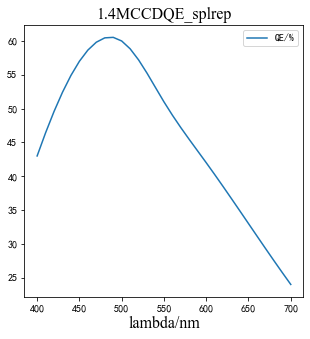

[172.      190.33717 208.22886 225.4103  241.60004 256.5     269.79414
 281.1493  290.21616 296.62787 300.      300.10899 297.44884 292.75133
 286.81398 280.5     274.54392 268.93797 263.46906 257.90611 252.
 245.53903 238.51214 230.9643  222.94336 214.5     205.68966 196.5713
 187.20604 177.65913 168.     ] 200 6.626e-17 3 0.001 3.6e-11


In [9]:

# 1.4MCCD量子效率三次样条插值
QE_data = scio.loadmat('data/Camera spectral response function/1.4MCCDQE_splrep.mat')['filters']
#rint(QE_data.shape)
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}
plt.figure(figsize=(5,5))
plt.title('1.4MCCDQE_splrep',font1)
plt.xlabel('lambda/nm',font1)
plt.plot(np.arange(400,710,10),QE_data)
plt.legend(['QE/%'])
#plt.savefig(img_path_data + '1.4MCCDQE_splrep.png')
plt.show()
QE_data = QE_data.reshape(-1,31)[-1]/100
wavelength_m = np.arange(400,710,10) # 10**-9m
all_filter = QE_data*wavelength_m # 波长和QE乘积

print(all_filter,K,h_p,c_light,tc,pixel_S)

image restruct start.
image restruct over.
spend time = 112s,average time for 1million pixel =20s 


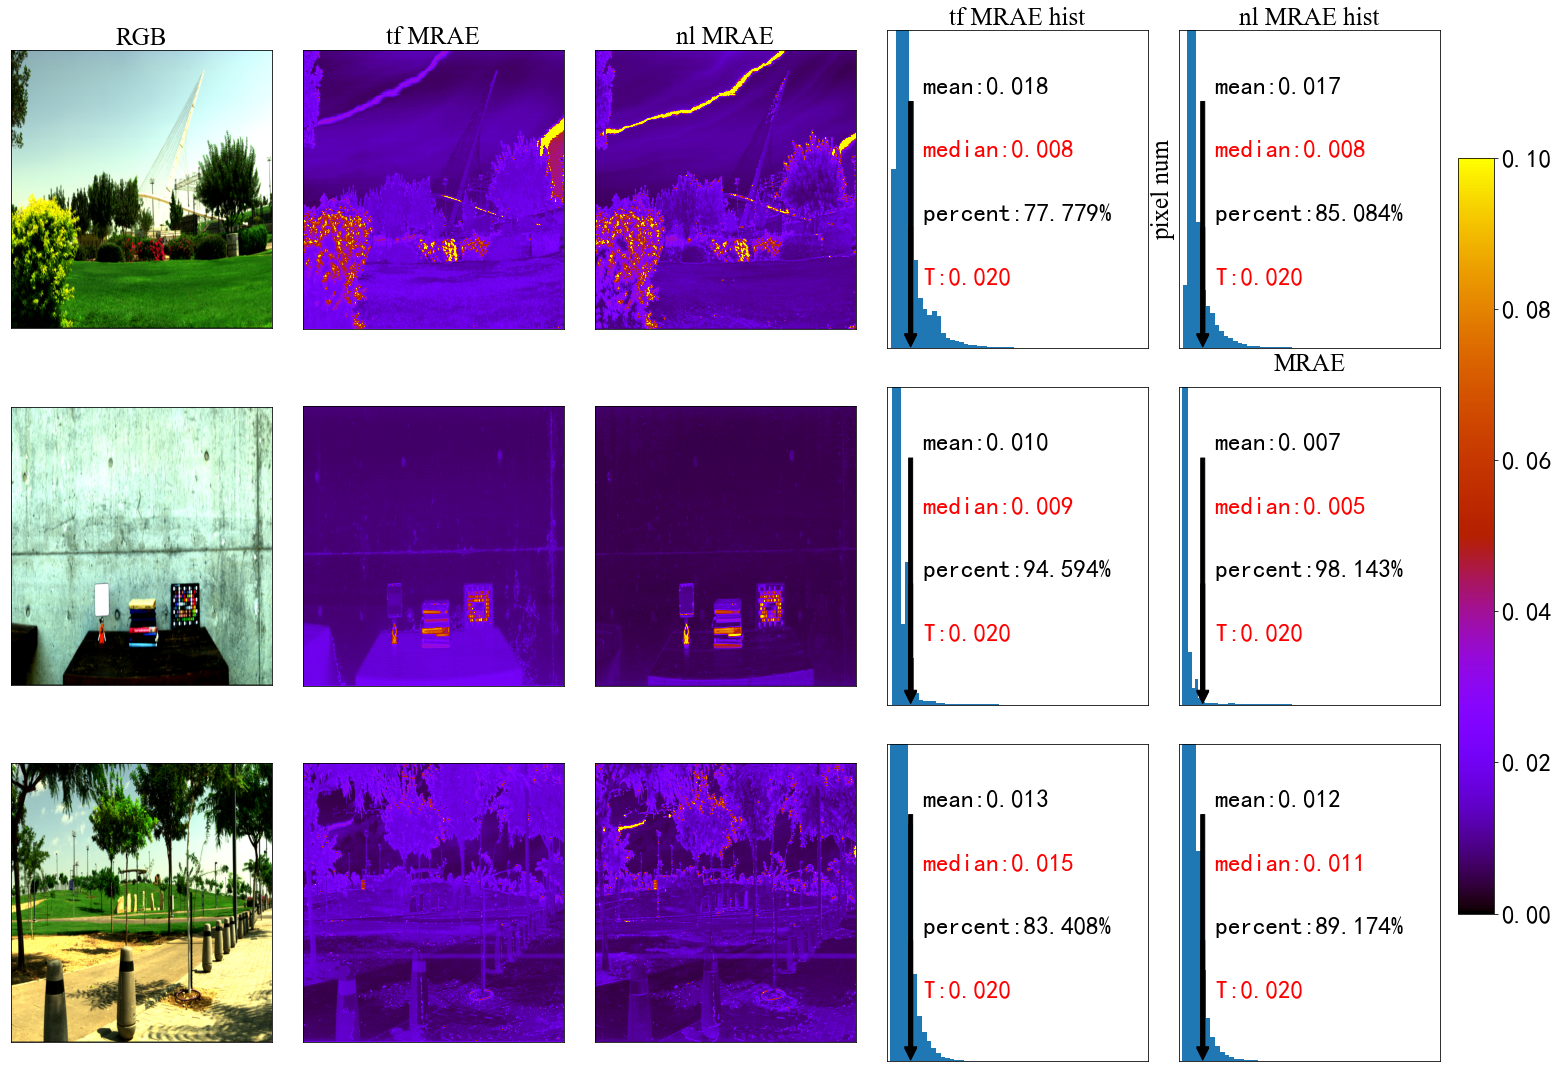

In [10]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
loss_MRAE = list_MRAELoss()
loss_T_limit=0.02
MRAE_limit = 0.1 # 0.22-0.45
# 两张训练图两张测试图
#plt.figure(figsize=(20,20))
font =  {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 25,
}
img_num = test_img_num+train_img_num # 图片展示数目
fig,axs= plt.subplots(img_num,5,figsize=(5*5,img_num*5))

import matplotlib
import time
#vnorm = matplotlib.colors.Normalize(vmin=0, vmax=0.15)
##################################  拿图片测试
pixel_num = 0
time_start = time.time()
print('image restruct start.')
for i in range(img_num):
    # 第一列 RGB图像
    path = all_img_list[i]
    origin_img = h5py.File(path,'r')         
    rad = origin_img['rad'][:].transpose(1,2,0) # 1390x1300x31
    rgb = origin_img['rgb'][:].transpose(2,1,0) # 1390x1300x3
    rad[rad<=0]=1 # 防除零和负数
    #print(rad.shape)
    ax0 = axs[i,0].imshow(rgb)

    if i==0:
        axs[i,0].set_title("RGB",font)
        
    axs[i,0].set_xticks(())
    axs[i,0].set_yticks(())
    del rgb,origin_img
   
    # 保留原始图片的分辨率信息
    orgin_shape = rad.shape
    pixel_W = torch.tensor(rad.reshape(-1,31)/all_filter*K*h_p*c_light/tc/pixel_S,device=device,dtype=dtype)
    pixel_num = pixel_num+pixel_W.shape[0]
    del rad
    # 0
    BatchSize = orgin_shape[1] # 以一行的像素数目为一个批次输出网络的像素数目
    for batch in range(orgin_shape[0]):
        ## 计算每个批次的误差
        tf_predict_mid = tf_hybnet(pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test),device_test)
        tf_MRAE_mid = np.round(loss_MRAE(tf_predict_mid , pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test)).to('cpu').detach().numpy(),4)
        nl_predict_mid = nolimit_hybnet(pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test),device_test)
        nl_MRAE_mid = np.round(loss_MRAE(nl_predict_mid , pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test)).to('cpu').detach().numpy(),4)
        ## 误差累加
        if batch ==0:
            tf_MRAE = tf_MRAE_mid
            nl_MRAE = nl_MRAE_mid
        else:
            tf_MRAE = np.concatenate([tf_MRAE,tf_MRAE_mid])
            nl_MRAE = np.concatenate([nl_MRAE,nl_MRAE_mid])
        del tf_MRAE_mid,nl_MRAE_mid

    # 恢复图像维度
    #MRAE_pixel16 = np.flip(MRAE_pixel16.reshape(orgin_shape[0],orgin_shape[1],1),0)
    new_tf_MRAE = np.flip(tf_MRAE.reshape(orgin_shape[0],orgin_shape[1],1),0)
    new_nl_MRAE = np.flip(nl_MRAE.reshape(orgin_shape[0],orgin_shape[1],1),0)
    
    #  第二列 薄膜方案  MRAE灰度图
    ax1 = axs[i,1].imshow(new_tf_MRAE,cmap='gnuplot',vmin=0, vmax=MRAE_limit)
    if i==0:
        axs[i,1].set_title("tf MRAE",font)
    axs[i,1].set_yticks(())
    axs[i,1].set_xticks(())

    #############################################################
    plt.tight_layout()
    #  第三列 不限制方案   MRAE灰度图
    ax2 = axs[i,2].imshow(new_nl_MRAE,cmap='gnuplot',vmin=0, vmax=MRAE_limit)
    if i==0:
        axs[i,2].set_title("nl MRAE",font)
    axs[i,2].set_yticks(())
    axs[i,2].set_xticks(())
    plt.tight_layout()

    #############################################################
    del new_tf_MRAE,new_nl_MRAE
    
    # 第四列 薄膜方案  直方图
    plt.subplot(img_num,5,i*5+4)
    #mid_pixel = np.sort(MRAE_pixel4)
    tf_MRAE.sort()

    draw_hist(tf_MRAE,0,
              0,0,0,0,fsize=25,loss_T=loss_T_limit,bar_num=int((0.22-0)/0.001))   # 直方图展示
    if i==0:
        plt.title("tf MRAE hist",font)
    plt.tight_layout()

    # 第五列 不限制方案 直方图
    plt.subplot(img_num,5,i*5+5)
    nl_MRAE.sort()

    draw_hist(nl_MRAE,0,
              0,0,0,0,fsize=25,loss_T=loss_T_limit,bar_num=int((0.22-0)/0.001))   # 直方图展示
    if i==0:
        plt.title("nl MRAE hist",font)
        plt.xlabel('MRAE',font)
        plt.ylabel('pixel num',font)
    plt.tight_layout()

    #############################################################
    del tf_MRAE,nl_MRAE
print('image restruct over.')
print('spend time = %ds,average time for 1million pixel =%ds '%((time.time()-time_start),(time.time()-time_start)/pixel_num*10**6))
########################################### 拿像素训练集测试 算了
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15,0.02, 0.7])
cb=fig.colorbar(ax1,ax=axs,cax=cbar_ax)
cb.ax.tick_params(labelsize=25)


fig.savefig(img_path_test+'%d张训练集+%d张测试集的MRAE（波长平均）灰度图+直方图_onlyICVL_两种结构对比_改cmap.png'%(train_img_num,test_img_num))
#del MRAE_pixel0,MRAE_pixel1,MRAE_pixel4,MRAE_pixel9
plt.show()
#plt.savefig(img_path_test+'2张训练集+2张测试集的MRAE（波长平均）灰度图.png')

# 最后一张图挑选几个点进行单像素光谱比较

In [11]:
select_pixel = 5 # pixel展示数目
time_start = time.time()
print('start.')
path = all_img_list[img_num-1]
origin_img = h5py.File(path,'r')         
rad = origin_img['rad'][:].transpose(1,2,0) # 1390x1300x31
del origin_img
rad[rad<=0]=1 # 防除零和负数
orgin_shape = rad.shape# 保留原始图片的分辨率信息
pixel_W = torch.tensor(rad.reshape(-1,31)/all_filter*K*h_p*c_light/tc/pixel_S,device=device,dtype=dtype)
del rad
BatchSize = orgin_shape[1] # 以一行的像素数目为一个批次输出网络的像素数目
for batch in range(orgin_shape[0]):
    ## 计算每个批次的误差
    tf_predict_mid = tf_hybnet(pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test),device_test)
    tf_MRAE_mid = np.round(loss_MRAE(tf_predict_mid , pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test)).to('cpu').detach().numpy(),4)
    nl_predict_mid = nolimit_hybnet(pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test),device_test)
    nl_MRAE_mid = np.round(loss_MRAE(nl_predict_mid , pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test)).to('cpu').detach().numpy(),4)
    ## 各像素误差拼接
    if batch ==0:
        tf_MRAE = tf_MRAE_mid
        nl_MRAE = nl_MRAE_mid
    else:
        tf_MRAE = np.concatenate([tf_MRAE,tf_MRAE_mid])
        nl_MRAE = np.concatenate([nl_MRAE,nl_MRAE_mid])
    del tf_MRAE_mid,nl_MRAE_mid
print(tf_MRAE.shape)


start.
(1809600, 1)


In [12]:

tf_new = np.ravel(tf_MRAE) # 转换(5,1)为(5,)
nl_new = np.ravel(nl_MRAE)
pixel_arr = np.arange(tf_MRAE.shape[0])
# 五个像素选择,两对最大最小，一个0.01
pixel_index = [pixel_arr[tf_new==tf_MRAE.min()][0]]
pixel_index = np.concatenate([pixel_index,[pixel_arr[nl_new==nl_MRAE.min()][0]]])
pixel_index = np.concatenate([pixel_index,[pixel_arr[tf_new==0.01][100]]])
pixel_index = np.concatenate([pixel_index,[pixel_arr[tf_new==tf_MRAE.max()][0]]])
pixel_index = np.concatenate([pixel_index,[pixel_arr[nl_new==nl_MRAE.max()][0]]])
# 预测
tf_predict_pixel = tf_hybnet(pixel_W[pixel_index,:].to(device_test),device_test).detach().numpy()
nl_predict_pixel =  nolimit_hybnet(pixel_W[pixel_index,:].to(device_test),device_test).detach().numpy()
print(pixel_index,tf_predict_pixel.shape,nl_predict_pixel.shape)



[1602205  352380    9540  989472  321937] (5, 31) (5, 31)


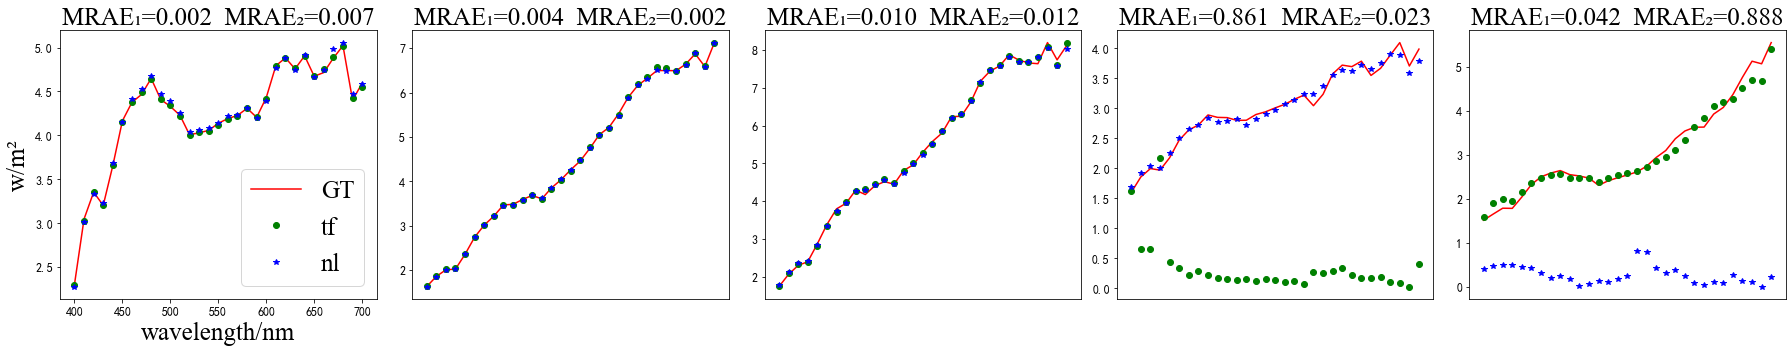

In [13]:
fig,axs= plt.subplots(1,select_pixel,figsize=(5*5,1*5))
#  第一列 薄膜方案  MRAE灰度图
for i in range(select_pixel):
    axs[i].plot(wavelength_m.tolist(),pixel_W[pixel_index[i],:],'r-',label='GT')#marker设置标记形状 markersize设置标记大小)
    axs[i].plot(wavelength_m.tolist(),tf_predict_pixel[i,:],'go',label='tf')#marker设置标记形状 markersize设置标记大小
    axs[i].plot(wavelength_m.tolist(),nl_predict_pixel[i,:],'b*',label='nl')#marker设置标记形状 markersize设置标记大小
    axs[i].set_title("MRAE₁=%0.3f  MRAE₂=%0.3f"%(tf_MRAE[pixel_index[i]],nl_MRAE[pixel_index[i]]),font)
    if i!=0:
        axs[i].set_xticks(())
    else:
        axs[i].set_xlabel("wavelength/nm",font)
        axs[i].set_ylabel("w/m²",font)
        axs[i].legend(prop = {'family' : 'Times New Roman','weight' : 'normal','size'   : 25})
    axs[i].tick_params(labelsize='large')
    plt.tight_layout()
fig.savefig(img_path_test+'onlyICVL_两种结构对比_单像素光谱_改cmap.png')

# 优化后的滤光片光谱响应函数对比

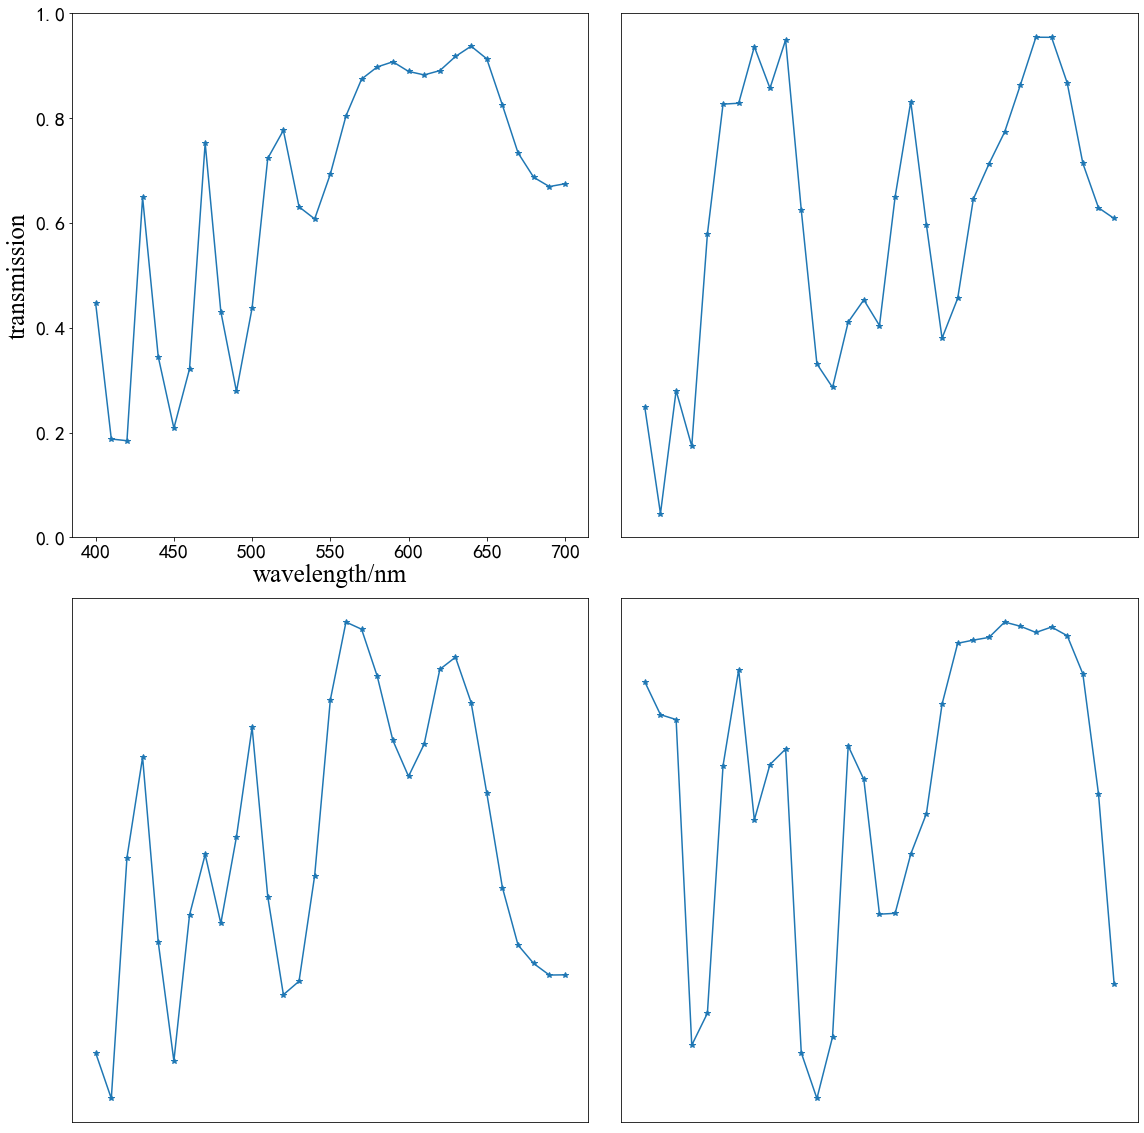

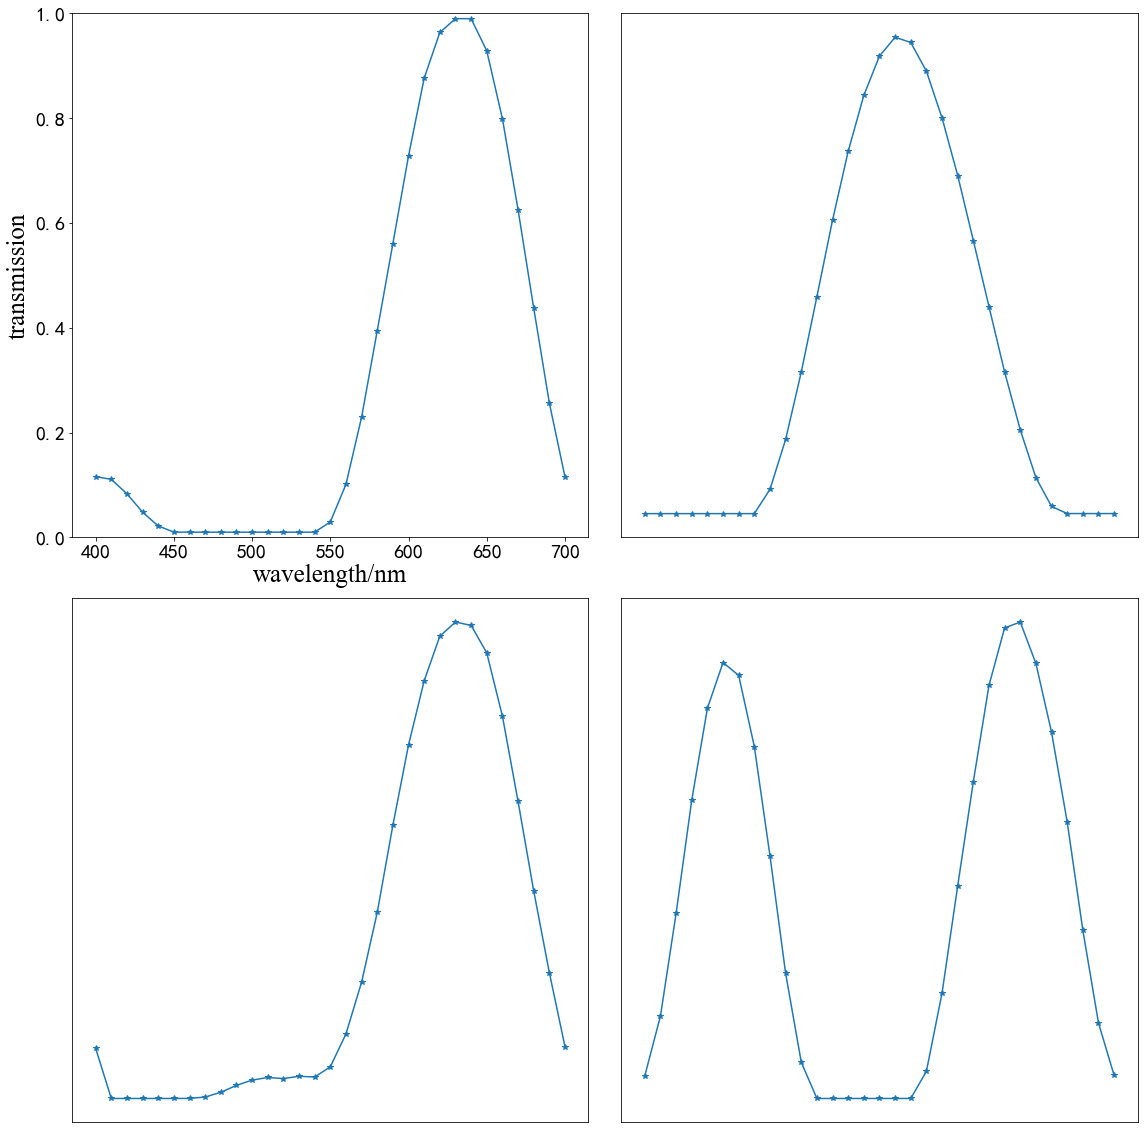

In [20]:
font =  {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 25,
}
plt.figure(figsize=(16,16))

filter_tf = tf_hybnet.run_FMN().to('cpu').detach().numpy()
filter_nl = nolimit_hybnet.show_BESTFs_T().to('cpu').detach().numpy()
i=4
for j in range(4):
    plt.subplot(int(i**0.5),int(i**0.5),j+1)
    plt.plot(wavelength_m,filter_tf[:,j],'-*')
    plt.tight_layout()
    if j==0:
        plt.ylim(0,1)
        plt.xlabel('wavelength/nm',font)
        plt.ylabel('transmission',font)
        plt.tick_params(labelsize = 20)
    else:
        plt.yticks(())
        plt.xticks(())

plt.savefig(img_path_test+'%d个随机滤波片的透过率函数onlyICVL_thin-film.png'%(i))
plt.show()

plt.figure(figsize=(16,16))
for j in range(4):
    plt.subplot(int(i**0.5),int(i**0.5),j+1)
    plt.plot(wavelength_m,filter_nl[:,j],'-*')
    plt.tight_layout()
    if j==0:
        plt.ylim(0,1)
        plt.xlabel('wavelength/nm',font)
        plt.ylabel('transmission',font)
        plt.tick_params(labelsize = 20)
    else:
        plt.yticks(())
        plt.xticks(())

plt.savefig(img_path_test+'%d个随机滤波片的透过率函数onlyICVL_non-limited.png'%(i))
plt.show()

# 无限制结构滤光片的3x3和4x4方案
## MRAE灰度图+直方图
## 单像素光谱图，同索引

In [21]:
TFNum = 9
T_min = torch.tensor([0])
T_max = torch.tensor([1])

file_name = '20210722_133542_W_onlyICVL_newNETandLoss_newTbeta_TFNum=%d'%(TFNum)
path = 'nets/hybnet/n+BEST-Fs_CinCCD/'+ file_name+'/'
for file in os.listdir(path):
    if file[-3:] =='pkl' and file.find('test')!=-1:
        checkpoint = torch.load(path+file)
        print(path+file)
        
train_param = scio.loadmat(path+'camera_informations.mat')
Specs_filter = torch.tensor(train_param['QE'],device=device_train)
TFNum = np.int(train_param['TFnum'])
K=np.int(train_param['K'])
tc=np.float(train_param['tc'])
h_p=np.float(train_param['h'])
c_light=np.int(train_param['c'])
pixel_S = np.float(train_param['pixel_S'])
hybnet_size = (train_param['hybnet_size']).reshape(-1).tolist()
beta_range = np.float(train_param['beta_range'])
T_beta = np.float(train_param['T_beta'])
nl_designed_param = train_param['designed_TF_BESTFs']

nolimit_hybnet9 = nolimit_HybridNet(T_min,T_max,K,tc,h_p,c_light,pixel_S,WL,Specs_filter,hybnet_size, device_train) 
nolimit_hybnet9.load_state_dict(checkpoint['state_dict'])# 模型参数读取
nolimit_hybnet9.to(device_train)
nolimit_hybnet9.eval()


nets/hybnet/n+BEST-Fs_CinCCD/20210722_133542_W_onlyICVL_newNETandLoss_newTbeta_TFNum=9/HybridNet_epoch=308_flag=test_loss=0.008.pkl


nolimit_HybridNet(
  (SWNet): Sequential(
    (BatchNorm0): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu0): PReLU(num_parameters=9)
    (Linear1): Linear(in_features=9, out_features=600, bias=True)
    (BatchNorm1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu1): PReLU(num_parameters=600)
    (Linear2): Linear(in_features=600, out_features=300, bias=True)
    (BatchNorm2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu2): PReLU(num_parameters=300)
    (Linear3): Linear(in_features=300, out_features=100, bias=True)
    (BatchNorm3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu3): PReLU(num_parameters=100)
    (Linear4): Linear(in_features=100, out_features=31, bias=True)
    (BatchNorm4): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu4): PReLU(num_parameters=31)


In [22]:
TFNum = 16
T_min = torch.tensor([0])
T_max = torch.tensor([1])

file_name = '20210722_161904_W_onlyICVL_newNETandLoss_newTbeta_TFNum=%d'%(TFNum)
path = 'nets/hybnet/n+BEST-Fs_CinCCD/'+ file_name+'/'
for file in os.listdir(path):
    if file[-3:] =='pkl' and file.find('test')!=-1:
        checkpoint = torch.load(path+file)
        print(path+file)
        
train_param = scio.loadmat(path+'camera_informations.mat')
Specs_filter = torch.tensor(train_param['QE'],device=device_train)
TFNum = np.int(train_param['TFnum'])
K=np.int(train_param['K'])
tc=np.float(train_param['tc'])
h_p=np.float(train_param['h'])
c_light=np.int(train_param['c'])
pixel_S = np.float(train_param['pixel_S'])
hybnet_size = (train_param['hybnet_size']).reshape(-1).tolist()
beta_range = np.float(train_param['beta_range'])
T_beta = np.float(train_param['T_beta'])
nl_designed_param = train_param['designed_TF_BESTFs']

nolimit_hybnet16 = nolimit_HybridNet(T_min,T_max,K,tc,h_p,c_light,pixel_S,WL,Specs_filter,hybnet_size, device_train) 
nolimit_hybnet16.load_state_dict(checkpoint['state_dict'])# 模型参数读取
nolimit_hybnet16.to(device_train)
nolimit_hybnet16.eval()


nets/hybnet/n+BEST-Fs_CinCCD/20210722_161904_W_onlyICVL_newNETandLoss_newTbeta_TFNum=16/HybridNet_epoch=314_flag=test_loss=0.009.pkl


nolimit_HybridNet(
  (SWNet): Sequential(
    (BatchNorm0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu0): PReLU(num_parameters=16)
    (Linear1): Linear(in_features=16, out_features=600, bias=True)
    (BatchNorm1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu1): PReLU(num_parameters=600)
    (Linear2): Linear(in_features=600, out_features=300, bias=True)
    (BatchNorm2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu2): PReLU(num_parameters=300)
    (Linear3): Linear(in_features=300, out_features=100, bias=True)
    (BatchNorm3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu3): PReLU(num_parameters=100)
    (Linear4): Linear(in_features=100, out_features=31, bias=True)
    (BatchNorm4): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu4): PReLU(num_parameters=3

image restruct start.
image restruct over.
spend time = 96s,average time for 1million pixel =17s 


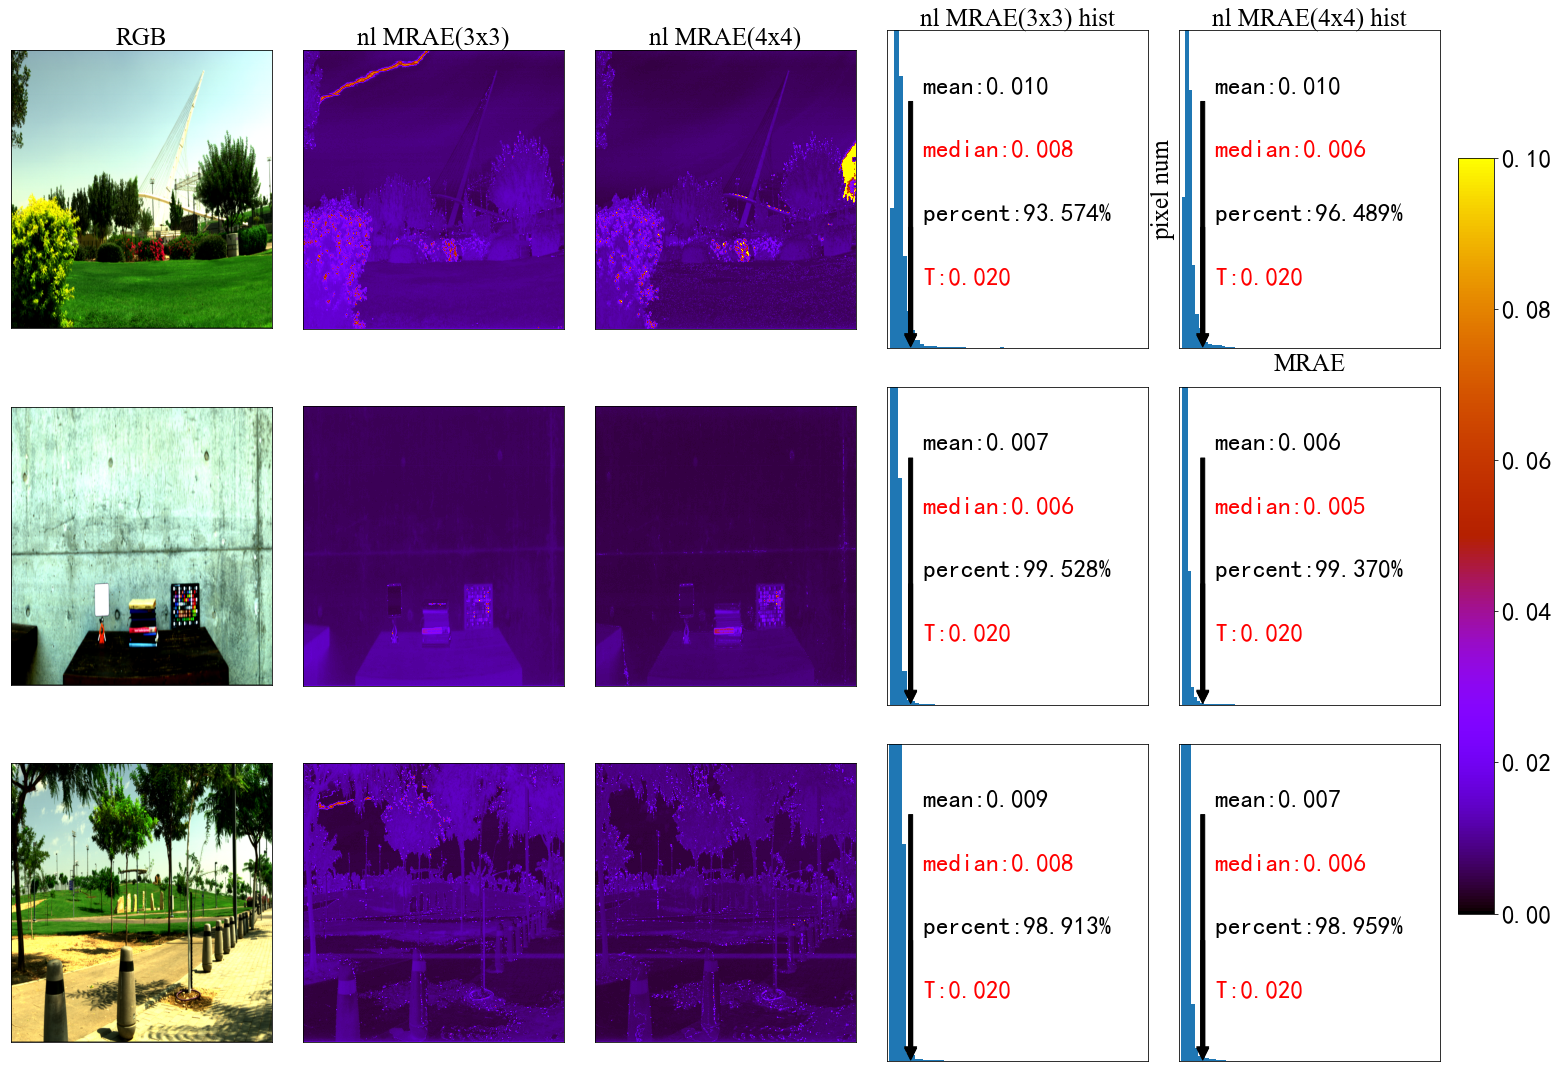

In [23]:
loss_MRAE = list_MRAELoss()
loss_T_limit=0.02
MRAE_limit = 0.1 # 0.22-0.45
# 两张训练图两张测试图
#plt.figure(figsize=(20,20))
font =  {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 25,
}
img_num = test_img_num+train_img_num # 图片展示数目
fig,axs= plt.subplots(img_num,5,figsize=(5*5,img_num*5))

#vnorm = matplotlib.colors.Normalize(vmin=0, vmax=0.15)
##################################  拿图片测试
pixel_num = 0
time_start = time.time()
print('image restruct start.')
for i in range(img_num):
    # 第一列 RGB图像
    path = all_img_list[i]
    origin_img = h5py.File(path,'r')         
    rad = origin_img['rad'][:].transpose(1,2,0) # 1390x1300x31
    rgb = origin_img['rgb'][:].transpose(2,1,0) # 1390x1300x3
    rad[rad<=0]=1 # 防除零和负数
    #print(rad.shape)
    ax0 = axs[i,0].imshow(rgb)

    if i==0:
        axs[i,0].set_title("RGB",font)
        
    axs[i,0].set_xticks(())
    axs[i,0].set_yticks(())
    del rgb,origin_img
   
    # 保留原始图片的分辨率信息
    orgin_shape = rad.shape
    pixel_W = torch.tensor(rad.reshape(-1,31)/all_filter*K*h_p*c_light/tc/pixel_S,device=device,dtype=dtype)
    pixel_num = pixel_num+pixel_W.shape[0]
    del rad
    # 0
    BatchSize = orgin_shape[1] # 以一行的像素数目为一个批次输出网络的像素数目
    for batch in range(orgin_shape[0]):
        ## 计算每个批次的误差
        nl9_predict_mid = nolimit_hybnet9(pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test),device_test)
        nl9_MRAE_mid = np.round(loss_MRAE(nl9_predict_mid , pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test)).to('cpu').detach().numpy(),4)
        nl16_predict_mid = nolimit_hybnet16(pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test),device_test)
        nl16_MRAE_mid = np.round(loss_MRAE(nl16_predict_mid , pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test)).to('cpu').detach().numpy(),4)
        ## 误差累加
        if batch ==0:
            nl9_MRAE = nl9_MRAE_mid
            nl16_MRAE = nl16_MRAE_mid
        else:
            nl9_MRAE = np.concatenate([nl9_MRAE,nl9_MRAE_mid])
            nl16_MRAE = np.concatenate([nl16_MRAE,nl16_MRAE_mid])
        del nl9_MRAE_mid,nl16_MRAE_mid

    # 恢复图像维度
    new_nl9_MRAE = np.flip(nl9_MRAE.reshape(orgin_shape[0],orgin_shape[1],1),0)
    new_nl16_MRAE = np.flip(nl16_MRAE.reshape(orgin_shape[0],orgin_shape[1],1),0)    
    #  第二列 薄膜方案  MRAE灰度图
    ax1 = axs[i,1].imshow(new_nl9_MRAE,cmap='gnuplot',vmin=0, vmax=MRAE_limit)
    if i==0:
        axs[i,1].set_title("nl MRAE(3x3)",font)
    axs[i,1].set_yticks(())
    axs[i,1].set_xticks(())

    #############################################################
    plt.tight_layout()
    #  第三列 不限制方案   MRAE灰度图
    ax2 = axs[i,2].imshow(new_nl16_MRAE,cmap='gnuplot',vmin=0, vmax=MRAE_limit)
    if i==0:
        axs[i,2].set_title("nl MRAE(4x4)",font)
    axs[i,2].set_yticks(())
    axs[i,2].set_xticks(())
    plt.tight_layout()

    #############################################################
    del new_nl9_MRAE,new_nl16_MRAE
    
    # 第四列 薄膜方案  直方图
    plt.subplot(img_num,5,i*5+4)
    #mid_pixel = np.sort(MRAE_pixel4)
    nl9_MRAE.sort()

    draw_hist(nl9_MRAE,0,
              0,0,0,0,fsize=25,loss_T=loss_T_limit,bar_num=int((0.22-0)/0.001))   # 直方图展示
    if i==0:
        plt.title("nl MRAE(3x3) hist",font)
    plt.tight_layout()

    # 第五列 不限制方案 直方图
    plt.subplot(img_num,5,i*5+5)
    nl16_MRAE.sort()

    draw_hist(nl16_MRAE,0,
              0,0,0,0,fsize=25,loss_T=loss_T_limit,bar_num=int((0.22-0)/0.001))   # 直方图展示
    if i==0:
        plt.title("nl MRAE(4x4) hist",font)
        plt.xlabel('MRAE',font)
        plt.ylabel('pixel num',font)
    plt.tight_layout()

    #############################################################
    del nl9_MRAE,nl16_MRAE
print('image restruct over.')
print('spend time = %ds,average time for 1million pixel =%ds '%((time.time()-time_start),(time.time()-time_start)/pixel_num*10**6))
########################################### 拿像素训练集测试 算了
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15,0.02, 0.7])
cb=fig.colorbar(ax1,ax=axs,cax=cbar_ax)
cb.ax.tick_params(labelsize=25)


fig.savefig(img_path_test+'%d张训练集+%d张测试集的MRAE（波长平均）灰度图+直方图_onlyICVL_不限制结构9与16方案_改cmap.png'%(train_img_num,test_img_num))
#del MRAE_pixel0,MRAE_pixel1,MRAE_pixel4,MRAE_pixel9
plt.show()
#plt.savefig(img_path_test+'2张训练集+2张测试集的MRAE（波长平均）灰度图.png')

In [24]:
select_pixel = 5 # pixel展示数目
time_start = time.time()
print('start.')
path = all_img_list[img_num-1]
origin_img = h5py.File(path,'r')         
rad = origin_img['rad'][:].transpose(1,2,0) # 1390x1300x31
del origin_img
rad[rad<=0]=1 # 防除零和负数
orgin_shape = rad.shape# 保留原始图片的分辨率信息
pixel_W = torch.tensor(rad.reshape(-1,31)/all_filter*K*h_p*c_light/tc/pixel_S,device=device,dtype=dtype)
del rad
BatchSize = orgin_shape[1] # 以一行的像素数目为一个批次输出网络的像素数目
for batch in range(orgin_shape[0]):
    ## 计算每个批次的误差
    nl9_predict_mid = nolimit_hybnet9(pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test),device_test)
    nl9_MRAE_mid = np.round(loss_MRAE(nl9_predict_mid , pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test)).to('cpu').detach().numpy(),4)
    nl16_predict_mid = nolimit_hybnet16(pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test),device_test)
    nl16_MRAE_mid = np.round(loss_MRAE(nl16_predict_mid , pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test)).to('cpu').detach().numpy(),4)
    ## 各像素误差拼接
    if batch ==0:
        nl9_MRAE = nl9_MRAE_mid
        nl16_MRAE = nl16_MRAE_mid
    else:
        nl9_MRAE = np.concatenate([nl9_MRAE,nl9_MRAE_mid])
        nl16_MRAE = np.concatenate([nl16_MRAE,nl16_MRAE_mid])
    del nl9_MRAE_mid,nl16_MRAE_mid
print(nl9_MRAE.shape)


start.
(1809600, 1)


[1602205  352380    9540  989472  321937] (5, 31) (5, 31)


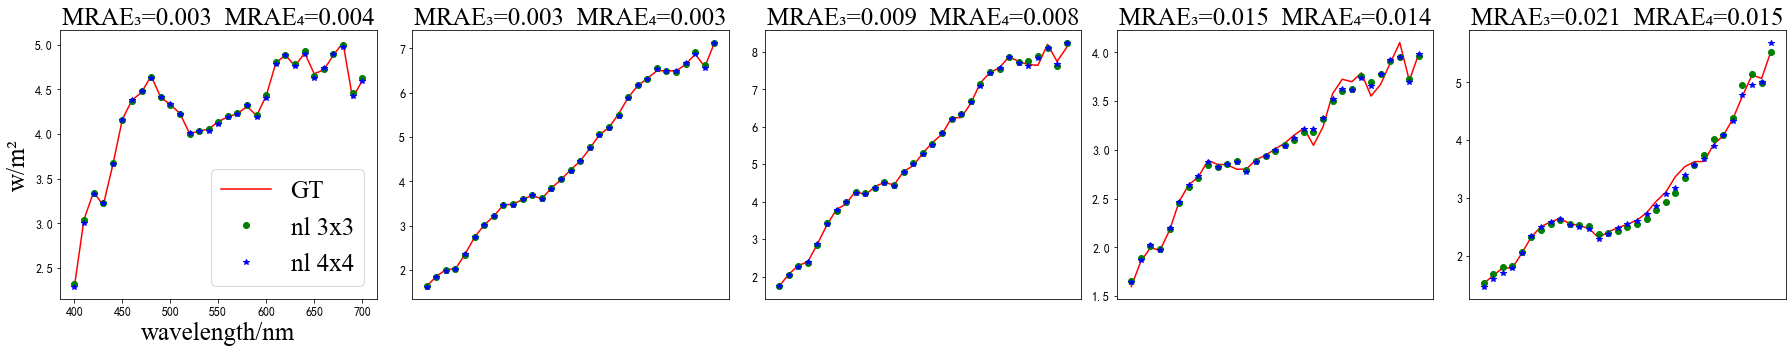

In [25]:
nl9_predict_pixel = nolimit_hybnet9(pixel_W[pixel_index,:].to(device_test),device_test).detach().numpy()
nl16_predict_pixel =  nolimit_hybnet16(pixel_W[pixel_index,:].to(device_test),device_test).detach().numpy()
print(pixel_index,nl9_predict_pixel.shape,nl16_predict_pixel.shape)
fig,axs= plt.subplots(1,select_pixel,figsize=(5*5,1*5))
#  第一列 薄膜方案  MRAE灰度图
for i in range(select_pixel):
    axs[i].plot(wavelength_m.tolist(),pixel_W[pixel_index[i],:],'r-',label='GT')#marker设置标记形状 markersize设置标记大小)
    axs[i].plot(wavelength_m.tolist(),nl9_predict_pixel[i,:],'go',label='nl 3x3')#marker设置标记形状 markersize设置标记大小
    axs[i].plot(wavelength_m.tolist(),nl16_predict_pixel[i,:],'b*',label='nl 4x4')#marker设置标记形状 markersize设置标记大小
    axs[i].set_title("MRAE₃=%0.3f  MRAE₄=%0.3f"%(nl9_MRAE[pixel_index[i]],nl16_MRAE[pixel_index[i]]),font)
    if i!=0:
        axs[i].set_xticks(())
    else:
        axs[i].set_xlabel("wavelength/nm",font)
        axs[i].set_ylabel("w/m²",font)
        axs[i].legend(prop = {'family' : 'Times New Roman','weight' : 'normal','size'   : 25})
    axs[i].tick_params(labelsize='large')
    plt.tight_layout()
fig.savefig(img_path_test+'onlyICVL_不限制结构9与16方案_单像素光谱_改cmap.png')